# Imports, loading dataset and utility functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cbottle.visualizations import visualize
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import os
import netCDF4 as nc

from grad_check import concat_dataset_and_extract_q_names, get_differences, load_conditioning_sst

In [ ]:
# path_to_folder = "inference_output/1971_2020_global_toa_rad_169h"
# path_to_folder = "inference_output/1990_2020_global_toa_rad_169h"
# path_to_folder = "inference_output/2020_north_atlantic_rlut_96h"
path_to_folder = "inference_output/2020_north_atlantic_rsut_24h_fixed_noise"
# path_to_folder = "inference_output/1-2July2021_TOA_rad_1h"
# path_to_folder = "inference_output/jan_feb_2021_toa_radiation"

# check if concatenated dataset exists
if not os.path.exists(os.path.join(path_to_folder, "concatenated_dataset.nc")):
    concatenated_ds, _ = concat_dataset_and_extract_q_names(path_to_folder, additional_vars=['rsut'])
    concatenated_ds.to_netcdf(os.path.join(path_to_folder, "concatenated_dataset.nc"))
else:
    concatenated_ds = xr.open_dataset(os.path.join(path_to_folder, "concatenated_dataset.nc"))

times = pd.to_datetime(concatenated_ds.time.values, unit='s')

In [3]:
def get_symmetric_colorbar_limits(x):
    # Get the 99th percentile to remove outliers
    vmin = np.percentile(x, 0.01)
    vmax = np.percentile(x, 99.99)

    # Set symmetric color limits based on the most extreme value
    if abs(vmin) > abs(vmax):
        vmax = -vmin
    else:
        vmin = -vmax
    return {'vmin': vmin, 'vmax': vmax}

In [ ]:
# Enable LaTeX rendering only if matplotlib can actually use LaTeX
def check_latex_available():
    """Test if matplotlib can actually use LaTeX by attempting a simple render."""
    import matplotlib
    
    # Save current backend and rcParams settings
    original_backend = matplotlib.get_backend()
    original_rcParams = plt.rcParams.copy()
    
    try:
        test_fig = plt.figure()
        test_ax = test_fig.add_subplot(111)
        # Try to enable LaTeX
        plt.rcParams['text.usetex'] = True
        # Attempt to render simple LaTeX text
        test_ax.text(0.5, 0.5, r'$\alpha$')
        test_fig.canvas.draw()
        plt.close(test_fig)
        # Restore backend and all original settings
        matplotlib.use(original_backend, force=True)
        plt.rcParams.update(original_rcParams)
        return True
    except Exception as e:
        # print(f"LaTeX not available for matplotlib: {e}")
        # Restore backend and all original settings
        matplotlib.use(original_backend, force=True)
        plt.rcParams.update(original_rcParams)
        return False
if check_latex_available():
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (14, 6)
    plt.rcParams['font.size'] = 16
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern Roman']
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
    print("LaTeX rendering enabled.")
else:
    print("LaTeX not available. Using default matplotlib rendering.")

LaTeX rendering enabled.


# Plot gradient-check figure

In [5]:
import torch
import cartopy.feature as cfeature
import cartopy.crs as ccrs

## Load SST

In [6]:
sst_conditioning = await load_conditioning_sst(times)   # only works in notebook, asyncio.run needs to be used in python script

SST data already exists at /home/alexd/.cache/cbottle/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc


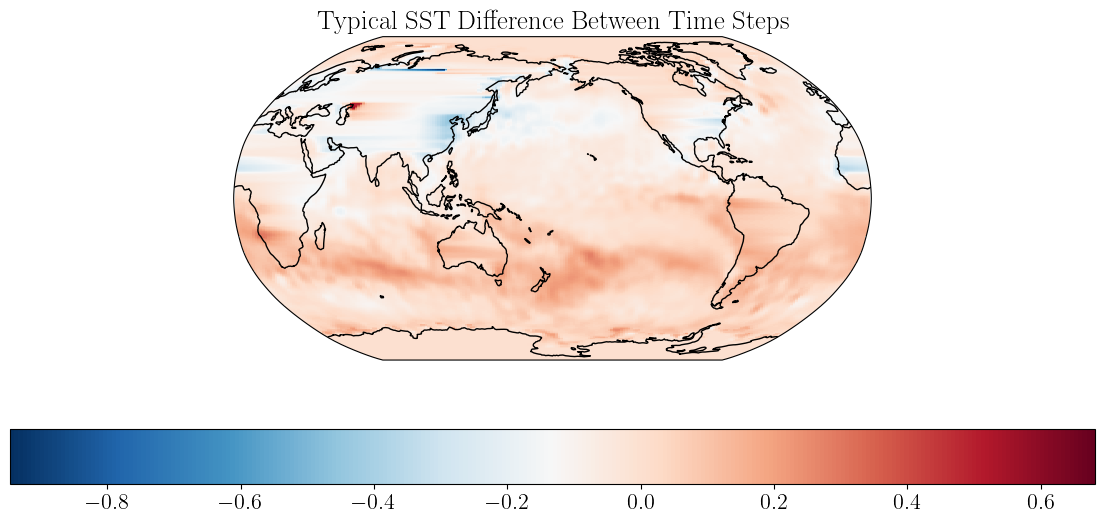

In [8]:
finite_diff_sst = torch.diff(sst_conditioning, dim=0)  # shape (time-1, hpx)
typical_sst_diff = finite_diff_sst[0]  # shape (hpx,)

visualize(typical_sst_diff.numpy(), region="Robinson_180", title="Typical SST Difference Between Time Steps", cmap='RdBu_r', add_colorbar=True)
plt.show()
plt.close()

## Plot

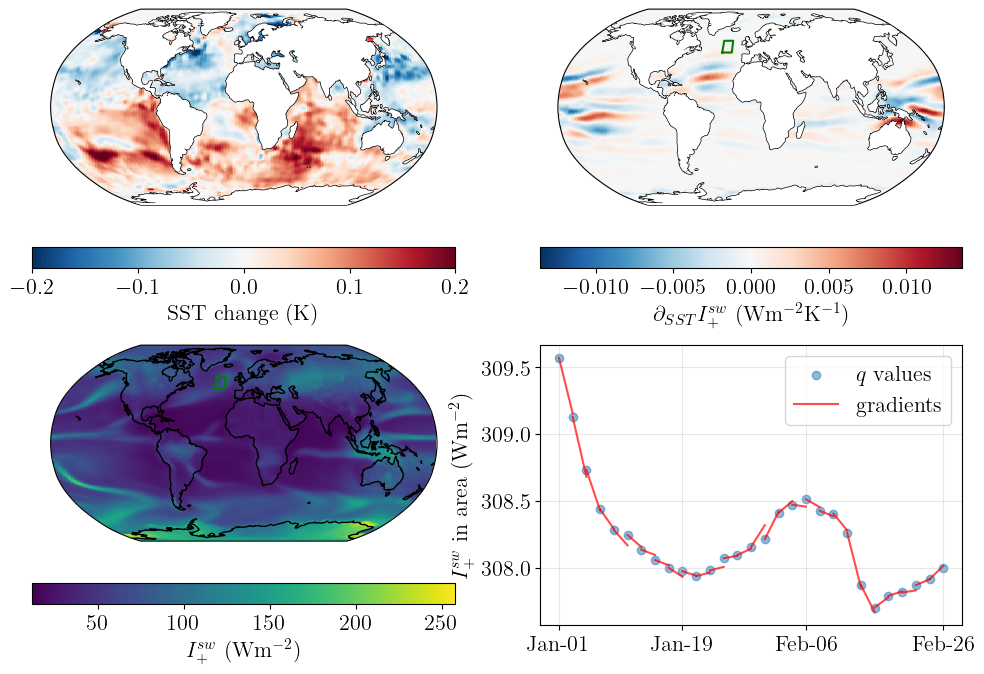

In [ ]:
time_idx = 9
channel_to_plot = "rsut"
q_name = "north_atlantic_rsut"
lon_min, lon_max, lat_min, lat_max = -30, -20, 45, 55
box_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
box_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]

# Reorder with increasing time
concatenated_ds = concatenated_ds.assign({'sst_conditioning': (('time', 'pix'), sst_conditioning)})
concatenated_ds = concatenated_ds.sortby('time')
sst_conditioning = torch.tensor(concatenated_ds['sst_conditioning'].data)
times = concatenated_ds.indexes['time']

q_values_dict, delta_q_finite_dict, linearized_delta_q_dict = get_differences(concatenated_ds, [q_name], sst_conditioning, times)

# Plot typical SST finite difference on the top left. Plot sensitivity map on the top right. Plot channel_to_plot on the bottom left. Plot the grad-check on the bottom right.
# Create figure with 2x2 subplots
fig = plt.figure(figsize=(12, 8))
sst_diff_cbar_limits = get_symmetric_colorbar_limits(finite_diff_sst[time_idx].numpy())
# Top-left: Typical SST finite difference
result_sst_diff = visualize(
    finite_diff_sst[time_idx].numpy(),
    region="Robinson",
    cmap='RdBu_r',
    vmin=-0.2,
    vmax=0.2,
    pos=(2, 2, 1),
    add_colorbar=True,
    colorbar_label="SST change (K)",
)
result_sst_diff.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')

# Top-right: sensitivity map
sensitivity_map = concatenated_ds[q_name + '_grad_sst'][time_idx].values
sensitivity_map_cbar_limits = get_symmetric_colorbar_limits(sensitivity_map)
result_sensitivity = visualize(
    sensitivity_map,
    region="Robinson",
    cmap='RdBu_r',
    **sensitivity_map_cbar_limits,
    pos=(2, 2, 2),
    add_colorbar=True,
    colorbar_label=r"$\partial_{SST} I_{+}^{sw}$ (Wm$^{-2}$K$^{-1}$)",
)
result_sensitivity.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')
result_sensitivity.ax.plot(box_lons, box_lats, color='green', linewidth=1.5, transform=ccrs.PlateCarree())

# Bottom-left: channel_to_plot
channel_data = concatenated_ds[channel_to_plot][time_idx].values
result_channel = visualize(
    channel_data,
    region="Robinson",
    cmap='viridis',
    pos=(2, 2, 3),
    add_colorbar=True,
    colorbar_label=r"$I_{+}^{sw}$ (Wm$^{-2}$)",
)
result_channel.ax.plot(box_lons, box_lats, color='green', linewidth=1.5, transform=ccrs.PlateCarree())

# Bottom-right: grad-check
num_values_to_plot = -1
q_values = q_values_dict[q_name][:num_values_to_plot]
delta_q_finite = delta_q_finite_dict[q_name][:num_values_to_plot]
linearized_delta_q = linearized_delta_q_dict[q_name][:num_values_to_plot]
times_to_plot = times[:num_values_to_plot]

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(range(len(q_values)), q_values.numpy(), label=r"$q$ values", alpha=0.5)
for t in range(len(linearized_delta_q)):    # only plot up to T-1 as that is how many finite diffs we have
    plt.plot([t, t+1], [q_values[t].item(), q_values[t].item() + linearized_delta_q[t].item()],label="gradients" if t==0 else None, color='red', alpha=0.7)

ax4.set_ylabel(r"$I_{+}^{sw}$ in area (Wm$^{-2}$)")
ax4.grid(True, alpha=0.3)
ax4.legend()
num_ticks = min(4, len(times_to_plot))
tick_indices = [int(i * (len(times_to_plot) - 1) / (num_ticks - 1)) for i in range(num_ticks)] if num_ticks > 1 else [0]
plt.xticks(tick_indices)
plt.gca().set_xticklabels([times_to_plot[i].strftime('%b-%d') for i in tick_indices], rotation=0)
plt.savefig(f"grad_check_{q_name}_{times[0].strftime('%Y-%m-%d')}_{times[num_values_to_plot].strftime('%Y-%m-%d')}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


## Re-plot Figure 2 for Camera-Ready version

### Plot one sensitivity map separately

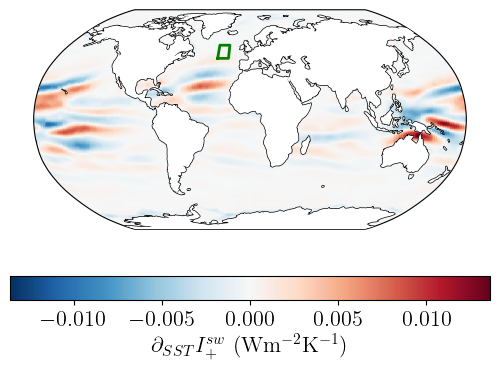

In [14]:
figure_scale_factor = 2.2
fig = plt.figure(figsize=(figure_scale_factor*2.4, figure_scale_factor*1.8))
result_sensitivity = visualize(
    sensitivity_map,
    region="Robinson",
    cmap='RdBu_r',
    **sensitivity_map_cbar_limits,
    add_colorbar=True,
    colorbar_label=r"$\partial_{SST} I_{+}^{sw}$ (Wm$^{-2}$K$^{-1}$)",
)
result_sensitivity.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')
result_sensitivity.ax.plot(box_lons, box_lats, color='green', linewidth=2, transform=ccrs.PlateCarree())
fig.tight_layout()
fig.savefig(f"sensitivity_map_{q_name}_{times[time_idx].strftime('%Y-%m-%d')}.png", dpi=int(500/figure_scale_factor), bbox_inches='tight')
plt.show()
plt.close()

### Fancy grad-check plot

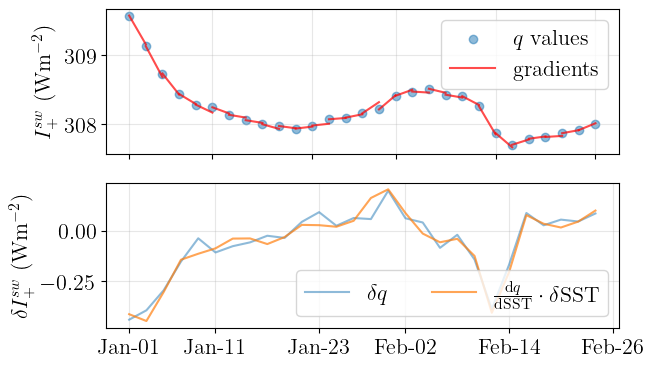

In [15]:
num_ticks = min(6, len(times_to_plot))
tick_indices = [int(i * (len(times_to_plot) - 1) / (num_ticks - 1)) for i in range(num_ticks)] if num_ticks > 1 else [0]

fig, axes = plt.subplots(2, 1, figsize=(figure_scale_factor*3.1, figure_scale_factor*1.8))
axes[0].scatter(range(len(q_values)), q_values.numpy(), label=r"$q$ values", alpha=0.5)
axes[0].set_ylabel(r"$I_{+}^{sw}$ (Wm$^{-2}$)")
axes[0].grid(True, alpha=0.3)
axes[0].set_xticklabels([])
for t in range(len(linearized_delta_q)):    # only plot up to T-1 as that is how many finite diffs we have
    axes[0].plot([t, t+1], [q_values[t].item(), q_values[t].item() + linearized_delta_q[t].item()],label="gradients" if t==0 else None, color='red', alpha=0.7)
axes[0].legend(ncols=1)
axes[0].set_xticks(tick_indices)
axes[1].plot(range(len(delta_q_finite)), delta_q_finite.numpy(), label=r"$\delta q$", alpha=0.5)
axes[1].plot(range(len(linearized_delta_q)), linearized_delta_q.numpy(), label=r"$\frac{\text{d} q}{\text{d} \text{SST}}\cdot \delta \text{SST}$", alpha=0.7)
axes[1].set_ylabel(r"$\delta I_{+}^{sw}$ (Wm$^{-2}$)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(ncol=2)
axes[1].set_xticks(tick_indices)
axes[1].set_xticklabels([times_to_plot[i].strftime('%b-%d') for i in tick_indices], rotation=0)
fig.tight_layout()
fig.savefig(f"fancy_grad_check_{q_name}_{times[0].strftime('%Y-%m-%d')}_{times[num_values_to_plot].strftime('%Y-%m-%d')}.png", dpi=int(500/figure_scale_factor), bbox_inches='tight')
plt.show()
plt.close()